<a href="https://colab.research.google.com/github/svetaepc/ds_py/blob/master/%D0%94%D0%97_%D0%92%D0%B2%D0%B5%D0%B4%D0%B5%D0%BD%D0%B8%D0%B5_%D0%B2_%D1%81%D0%B2%D0%B5%D1%80%D1%82%D0%BE%D1%87%D0%BD%D1%8B%D0%B5_%D0%9D%D0%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание. Свёрточные сети

Здесь вам предстоит построить и обучить свою первую свёрточную сеть для классификации изображений на данных CIFAR10.

# Домашнее задание. Свёрточные сети

Здесь вам предстоит построить и обучить свою первую свёрточную сеть для классификации изображений на данных CIFAR10.

In [ ]:
import tensorflow as tf

from tqdm import tqdm_notebook

## Данные

CIFAR10
* 60000 RGB изображений размером 32x32x3
* 10 классов: самолёты, собаки, рыбы и т.п.

<img src="https://www.samyzaf.com/ML/cifar10/cifar1.jpg" style="width:60%">

Загрузите данные, разделите их на обучающую и тестовую выборки. Размер тестовой выборки должен быть $10^4$.

In [ ]:
import numpy as np
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=10**4, random_state=42)

class_names = np.array(['airplane','automobile ','bird ','cat ','deer ','dog ','frog ','horse ','ship ','truck'])

print (X_train.shape,y_train.shape)

170498071/170498071 [==============================] - 3s 0us/step
(40000, 32, 32, 3) (40000, 1)


Прежде чем приступать к основной работе, стоит убедиться что загруженно именно то, что требовалось:

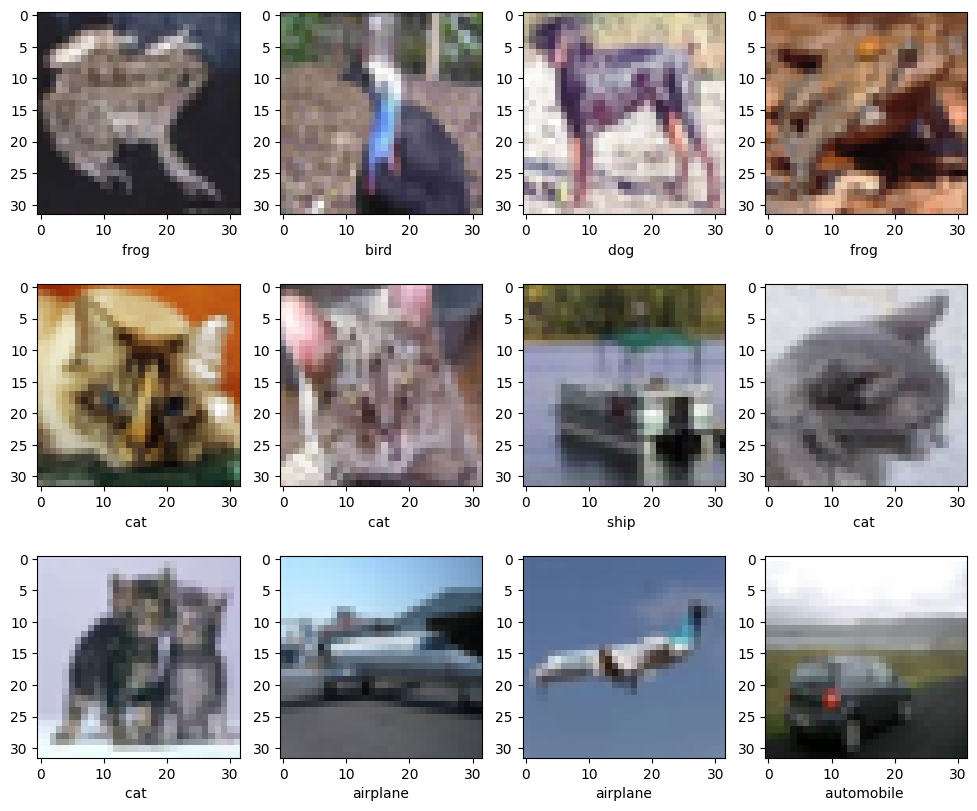

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[12,10])
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.xlabel(class_names[y_train[i, 0]])
    plt.imshow(X_train[i])

## Подготовка данных

Сейчас каждый пиксель изображения закодирован тройкой чисел (RGB) __от 0 до 255__. Однако лучше себя показывает подход, где значения входов нейросети распределены недалеко от 0.

Давайте приведём все данные в диапазон __`[0, 1]`__ — просто разделим на соответствующий коэффициент:

In [ ]:
X_train = X_train / 255
X_val = X_val / 255
X_test = X_test / 255

Исполните код ниже для проверки, что все выполнено корректно.

In [ ]:
assert np.shape(X_train) == (40000, 32, 32, 3), "data shape should not change"
assert 0.9 <= max(map(np.max, (X_train, X_val, X_test))) <= 1.05
assert 0.0 <= min(map(np.min, (X_train, X_val, X_test))) <= 0.1
assert len(np.unique(X_test / 255.)) > 10, "make sure you casted data to float type"

## Архитектура сети

Для начала реализуйте простую нейросеть:
1. принимает на вход картинки размера 32 x 32 x 3;
2. вытягивает их в вектор (`keras.layers.Flatten`);
3. пропускает через 1 или 2 полносвязных слоя;
4. выходной слой отдает вероятности принадлежности к каждому из 10 классов.

Создайте полносвязную сеть:

In [ ]:
import keras
from keras import layers as L
from keras import backend as K

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(32, 32, 3)),
    keras.layers.Dense(128, activation='tanh'),
    keras.layers.Dense(10, activation='softmax')])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 128)               393344    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 394,634
Trainable params: 394,634
Non-trainable params: 0
_________________________________________________________________


In [ ]:
dummy_pred = model.predict(X_train[:20])
assert dummy_pred.shape == (20, 10)
assert np.allclose(dummy_pred.sum(-1), 1)
print("Успех!")

1/1 [==============================] - 0s 436ms/step
Успех!


## Обучение сети

**Задание 1.1 (обязательно)** Будем минимизировать многоклассовую кроссэкнропию с помощью __sgd__. Вам нужно получить сеть, которая достигнет __не менее 45%__ __accuracy__ на тестовых данных.

__Важно:__ поскольку в y_train лежат номера классов, Керасу нужно либо указать sparse функции потерь и метрики оценки качества классификации (`sparse_categorical_crossentropy` и `sparse_categorical_accuracy`), либо конвертировать метки в one-hot формат.

### Полезные советы
* `model.compile` позволяет указать, какие метрики вы хотите вычислять.
* В `model.fit` можно передать валидационную выборку (`validation_data=[X_val, y_val]`), для отслеживания прогресса на ней. Также рекомендуем сохранять результаты в [tensorboard](https://keras.io/callbacks/#tensorboard) или [wandb](https://docs.wandb.ai/integrations/jupyter). **Важно: логи tensorboard не получится без боли посмотреть через colab.** Workaround: скачать логи и запустить tensorboard локально или помучаться [с этим](https://stackoverflow.com/questions/47818822/can-i-use-tensorboard-with-google-colab).
* По умолчанию сеть учится 1 эпоху. Совсем не факт, что вам этого хватит. Число эпох можно настроить в методе `fit` (`epochs`).
* Ещё у Кераса есть много [полезных callback-ов](https://keras.io/callbacks/), которые можно попробовать. Например, автоматическая остановка или подбор скорости обучения.

In [ ]:
y_train, y_val = (keras.utils.to_categorical(y) for y in (y_train, y_val))

In [ ]:
callbacks =[
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                     patience=2),
    tf.keras.callbacks.ModelCheckpoint(filepath='model_best_{epoch}.h5',
                                             monitor='val_accuracy',
                                             verbose=1,
                                             save_best_only=True,
                                             save_weights_only=False,
                                             mode='auto',
                                             save_freq='epoch') ,
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

In [ ]:
model.compile(optimizer='SGD',
              loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

In [ ]:
validation_data=[X_val, y_val]

In [ ]:
model.fit(X_train, y_train,
          epochs=25,
          validation_data=validation_data,
          callbacks=callbacks)

Epoch 1/25
1245/1250 [============================>.] - ETA: 0s - loss: 1.9113 - accuracy: 0.3173
Epoch 1: val_accuracy improved from -inf to 0.35980, saving model to model_best_1.h5
1250/1250 [==============================] - 9s 6ms/step - loss: 1.9106 - accuracy: 0.3174 - val_loss: 1.8017 - val_accuracy: 0.3598
Epoch 2/25
1238/1250 [============================>.] - ETA: 0s - loss: 1.7563 - accuracy: 0.3864
Epoch 2: val_accuracy improved from 0.35980 to 0.39950, saving model to model_best_2.h5
1250/1250 [==============================] - 7s 6ms/step - loss: 1.7560 - accuracy: 0.3869 - val_loss: 1.7023 - val_accuracy: 0.3995
Epoch 3/25
1238/1250 [============================>.] - ETA: 0s - loss: 1.6873 - accuracy: 0.4073
Epoch 3: val_accuracy did not improve from 0.39950
1250/1250 [==============================] - 6s 5ms/step - loss: 1.6869 - accuracy: 0.4076 - val_loss: 1.6892 - val_accuracy: 0.3983
Epoch 4/25
1244/1250 [============================>.] - ETA: 0s - loss: 1.6402 - ac

А теперь можно проверить качество вашей сети, выполнив код ниже:

In [ ]:
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(y_test, np.argmax(model.predict(X_test), axis=-1))
print("\n Test_acc =", test_acc)
assert test_acc > 0.45, "Not good enough. Back to the drawing board :)"
print(" Not bad!")

313/313 [==============================] - 1s 2ms/step

 Test_acc = 0.454
 Not bad!


## Карманная сверточная сеть

**Задание 1.2 (обязательно)** Реализуйте небольшую свёрточную сеть. Совсем небольшую:
1. Входной слой
2. Свёртка 3x3 с 10 фильтрами
3. Нелинейность на ваш вкус
4. Max-pooling 2x2
5. Вытягиваем оставшееся в вектор (Flatten)
6. Полносвязный слой на 100 нейронов
7. Нелинейность на ваш вкус
8. Выходной полносвязный слой с softmax

Обучите её так же, как и предыдущую сеть. Если всё хорошо, у вас получится accuracy не меньше __50%__.

In [ ]:
model_new = keras.models.Sequential([
    keras.layers.Conv2D(filters=10,
                        kernel_size=(3, 3),
                        padding='same',
                        activation='tanh'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation='tanh'),
    keras.layers.Dense(10, activation='softmax')])

In [ ]:
model_new.compile(optimizer='SGD',
              loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

In [ ]:
model_new.fit(X_train, y_train,
          epochs=25,
          validation_data=validation_data,
          callbacks=callbacks)

Epoch 1/25
1249/1250 [============================>.] - ETA: 0s - loss: 1.8780 - accuracy: 0.3316
Epoch 1: val_accuracy did not improve from 0.45710
1250/1250 [==============================] - 34s 26ms/step - loss: 1.8777 - accuracy: 0.3318 - val_loss: 1.6872 - val_accuracy: 0.4029
Epoch 2/25
1248/1250 [============================>.] - ETA: 0s - loss: 1.6334 - accuracy: 0.4273
Epoch 2: val_accuracy did not improve from 0.45710
1250/1250 [==============================] - 30s 24ms/step - loss: 1.6334 - accuracy: 0.4274 - val_loss: 1.5613 - val_accuracy: 0.4512
Epoch 3/25
1250/1250 [==============================] - ETA: 0s - loss: 1.5193 - accuracy: 0.4697
Epoch 3: val_accuracy improved from 0.45710 to 0.47810, saving model to model_best_3.h5
1250/1250 [==============================] - 30s 24ms/step - loss: 1.5193 - accuracy: 0.4697 - val_loss: 1.4871 - val_accuracy: 0.4781
Epoch 4/25
1249/1250 [============================>.] - ETA: 0s - loss: 1.4349 - accuracy: 0.4994
Epoch 4: val_

Давайте посмотрим, смогла ли карманная сверточная сеть побить заданный порог по качеству:

In [ ]:
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(y_test, np.argmax(model_new.predict(X_test), axis=-1))
print("\n Test_acc =", test_acc)
assert test_acc > 0.50, "Not good enough. Back to the drawing board :)"
print(" Not bad!")

313/313 [==============================] - 3s 9ms/step

 Test_acc = 0.6136
 Not bad!


Для обработки больших изображений можно модифицировать данную нейронную сеть, добавив дополнительные слои, которые будут уменьшать размерность изображения перед подачей его на вход Conv2D слоям.

Примерно таким образом можно обработать большие изображения:


<image src="https://machinelearningmastery.ru/img/0-782701-562729.png" >

<image src="https://russianblogs.com/images/124/67c397c25358ebde5fc62f465c91829c.png" >


In [ ]:
model_1 = keras.models.Sequential([
    """ Conv2D - сверточный слой, содержит 10 фильтров размером
    3х3 с функцией активации гиперболический тангенс (tanh) и использует
    padding параметр для сохранения размерности входных данных"""
    keras.layers.Conv2D(filters=10, kernel_size=(3, 3), padding='same', activation='tanh'),
    """MaxPooling2D - слой пулинга, уменьшает размер изображения в 2 раза по каждой оси"""
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #  Conv2D - сверточный слой с 20 фильтрами
    keras.layers.Conv2D(filters=20, kernel_size=(3, 3), padding='same', activation='tanh'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    # Conv2D - сверточный слой с 30 фильтрами
    keras.layers.Conv2D(filters=30, kernel_size=(3, 3), padding='same', activation='tanh'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    # Flatten - слой преобразования данных в одномерный массив
    keras.layers.Flatten(),
    #  полносвязный слой с 100 нейронами и функцией активации гиперболический тангенс (tanh)
    keras.layers.Dense(units=100, activation='tanh'),
    """полносвязный слой с 10 нейронами и функцией активации softmax
    для предсказания вероятности принадлежности к каждому из 10 классов. """
    keras.layers.Dense(units=10, activation='softmax')
])


В данном примере добавлено 2 дополнительных Conv2D слоя с уменьшением размерности до 1/4 перед первым MaxPooling2D слоем. Соответственно, размерность изображения уменьшается до 1/8 по каждой из осей, что позволяет эффективнее обрабатывать большие изображения в сравнении с предыдущей сетью.

Необходимо учитывать, что при такой модификации можно потерять некоторую информацию изображения, и необходимо выбрать оптимальные значения параметров для каждого слоя в зависимости от задачи классификации.


In [ ]:
model_1.compile(optimizer='SGD',
              loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

In [ ]:
model_1.fit(X_train, y_train,
          epochs=25,
          validation_data=validation_data,
          callbacks=callbacks)

Epoch 1/25
1249/1250 [============================>.] - ETA: 0s - loss: 1.9521 - accuracy: 0.3042
Epoch 1: val_accuracy did not improve from 0.61710
1250/1250 [==============================] - 48s 38ms/step - loss: 1.9519 - accuracy: 0.3043 - val_loss: 1.7300 - val_accuracy: 0.3873
Epoch 2/25
1250/1250 [==============================] - ETA: 0s - loss: 1.6031 - accuracy: 0.4297
Epoch 2: val_accuracy did not improve from 0.61710
1250/1250 [==============================] - 49s 39ms/step - loss: 1.6031 - accuracy: 0.4297 - val_loss: 1.5070 - val_accuracy: 0.4622
Epoch 3/25
1250/1250 [==============================] - ETA: 0s - loss: 1.4356 - accuracy: 0.4891
Epoch 3: val_accuracy did not improve from 0.61710
1250/1250 [==============================] - 48s 39ms/step - loss: 1.4356 - accuracy: 0.4891 - val_loss: 1.3718 - val_accuracy: 0.5081
Epoch 4/25
1249/1250 [============================>.] - ETA: 0s - loss: 1.3288 - accuracy: 0.5301
Epoch 4: val_accuracy did not improve from 0.61710

In [ ]:
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(y_test, np.argmax(model_new.predict(X_test), axis=-1))
print("\n Test_acc =", test_acc)
assert test_acc > 0.50, "Not good enough. Back to the drawing board :)"
print(" Not bad!")

313/313 [==============================] - 3s 9ms/step

 Test_acc = 0.6136
 Not bad!
